# Time Stamp Extract

Brief 1-2 sentence description of notebook.

- Notebook that extracts the timestamps and gets the time that tones played

In [1]:
# Imports of all used packages and libraries
import os
import sys
import glob
from collections import defaultdict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
import trodes.read_exported

## Inputs & Data

- Explanation of each input and where it comes from.

Inputs and Required data loading
- input variable names are in all caps snake case
- Whenever an input changes or is used for processing 
- The variables are all lower in snake case

In [5]:
# Path of the directory that contains the Spike Gadgets recording and the exported timestamp files
# Exported with this tool https://docs.spikegadgets.com/en/latest/basic/ExportFunctions.html
# Export these files:
    # -raw – Continuous raw band export.
    # -dio – Digital IO channel state change export.
    # -analogio – Continuous analog IO export.
INPUT_DIR = "../../data"
INPUT_GLOB = "../../data/spike_gadgets/*.rec"
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs
TONE_DIN = "dio_ECU_Din2"
TONE_STATE = 1
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce"

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Other documentation

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

## Functions

- function names are short and in snake case all lowercase
- a function name should be unique but does not have to describe the function
- doc strings describe functions not function names

In [6]:
def find_closest_index(sorted_list=None, target=0):
    """
    Returns the index of the number in the sorted list that is closest to the target.

    This function performs a binary search on a sorted list to find the closest number to 
    a given target. If the target exists in the list, its index is returned. If not, the 
    function will return the index of the number that's closest to the target.

    Parameters:
    - sorted_list (list[int or float]): A sorted list of numbers.
    - target (int or float): The target number to find the closest value to.

    Returns:
    - int: The index of the closest number in the sorted list to the target. 
           If the sorted list is empty, returns None.

    Example:
    >>> sorted_nums = [1, 3, 5, 8, 10, 15, 18, 20, 24, 27, 30]
    >>> find_closest_index(sorted_nums, 6)
    2

    Note:
    The list should be sorted in ascending order.
    """
    
    if sorted_list is None:
        return None
    if target <= sorted_list[0]:
        return 0
    if target >= sorted_list[-1]:
        return len(sorted_list) - 1

    # Binary search
    left, right = 0, len(sorted_list) - 1
    while left <= right:
        mid = (left + right) // 2

        if sorted_list[mid] == target:
            return mid
        elif sorted_list[mid] < target:
            left = mid + 1
        else:
            right = mid - 1

    # After binary search, the target will be between sorted_list[right] and sorted_list[left]
    # We compare the two to see which one is closer to the target and return its index
    if abs(sorted_list[left] - target) < abs(sorted_list[right] - target):
        return left
    else:
        return right

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [7]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

In [8]:
all_session_files = glob.glob(INPUT_GLOB)

In [9]:
all_session_files

['../../data/spike_gadgets/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec']

# LOOP 1: Extracting all the Trodes

- Getting all the data from all the exported Trodes files

In [10]:
session_to_dir = {}
session_to_path = {}
# Going through each session recording
# Which includes all the recordings from all the miniloggers and cameras
for session_path in all_session_files:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        session_to_dir[session_basename] = trodes.read_exported.organize_all_trodes_export(session_path)
        session_to_path[session_basename] = session_path
    except Exception as e: 
        print(e)


Current Session: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1


/nancy/projects/nose_poke_identifier/results/2023_09_07_nose_poke_extraction/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Skipping file 20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.timestampoffset.txt due to error: Settings format not supported
Skipping file 20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.timestampoffset.txt due to error: Settings format not supported


# LOOP 2: Extracting the timestamps for the raw ephys recording

20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
dio_ECU_Din4


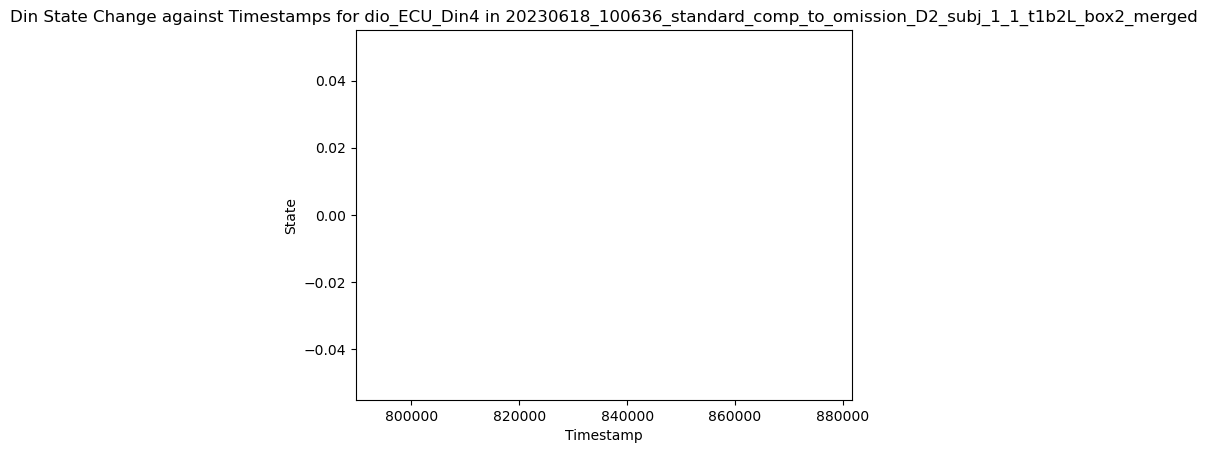

dio_ECU_Din3


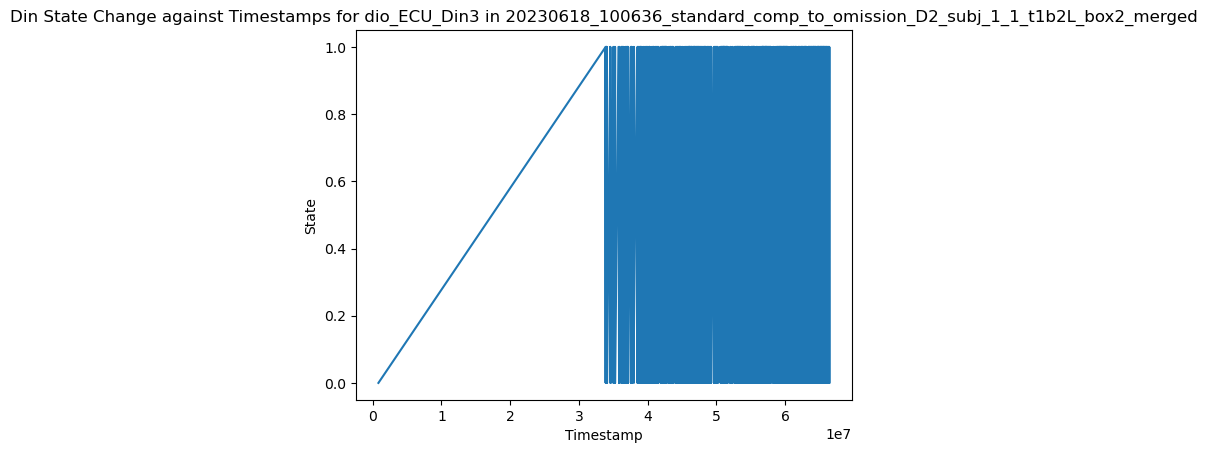

dio_ECU_Din2


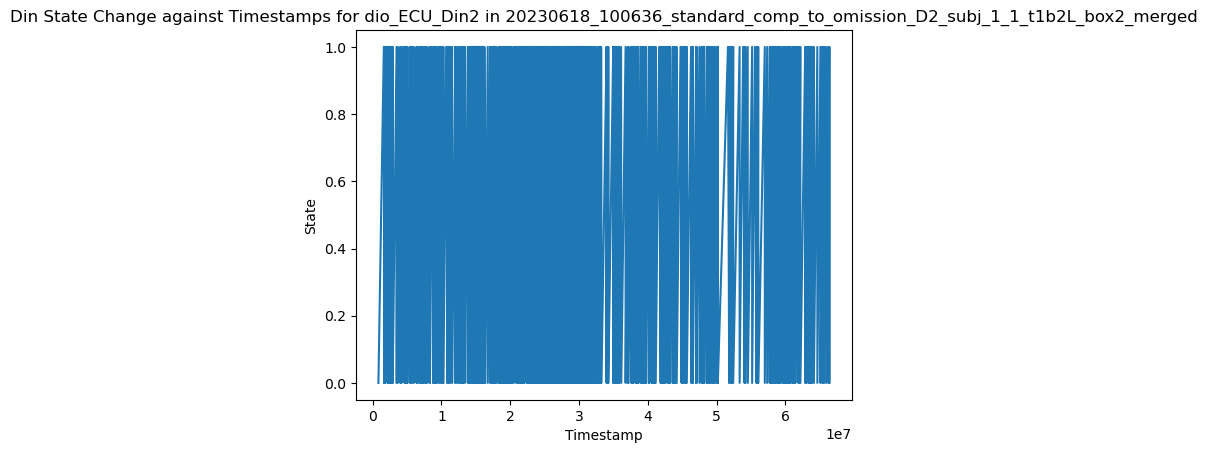

dio_ECU_Din1


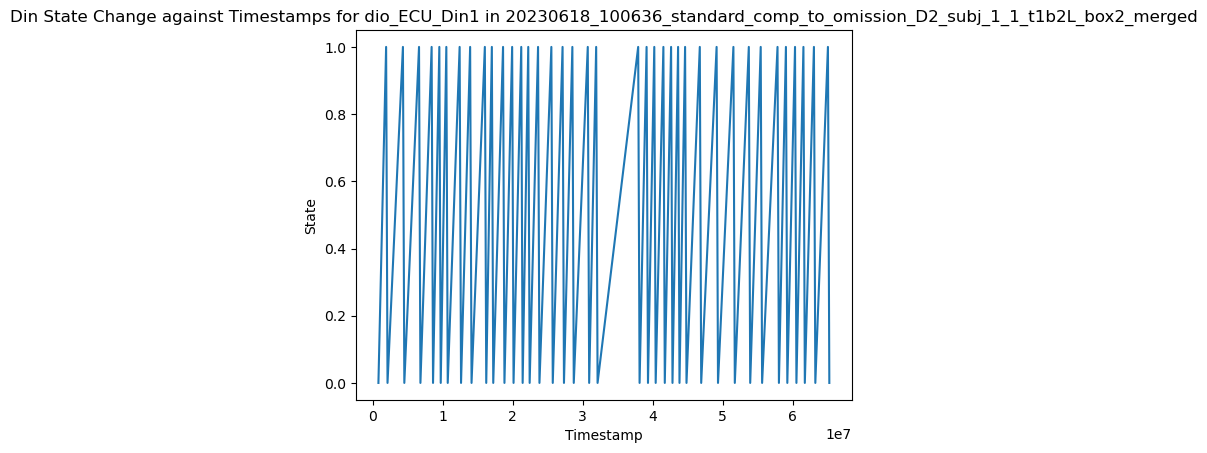

20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged
dio_ECU_Din2


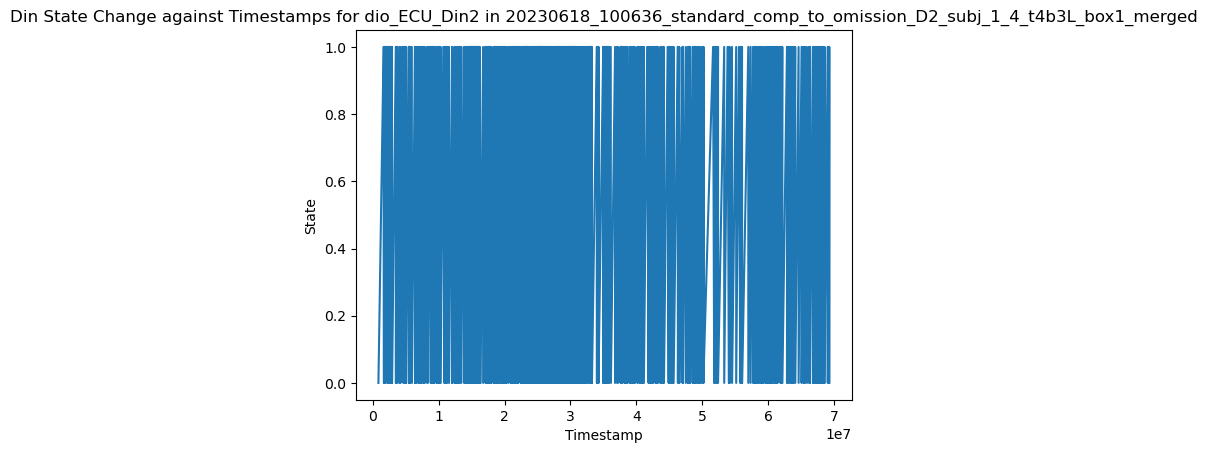

dio_ECU_Din3


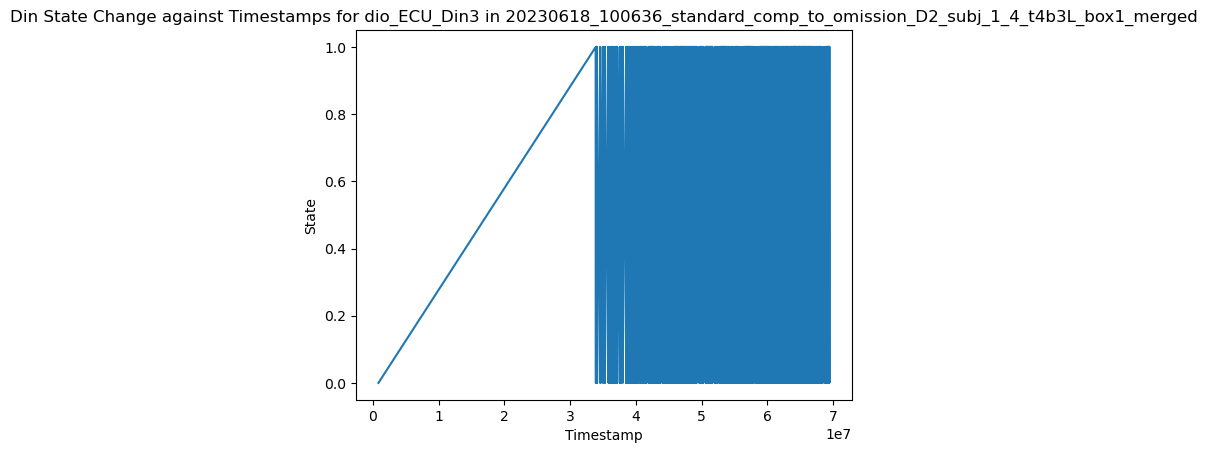

dio_ECU_Din4


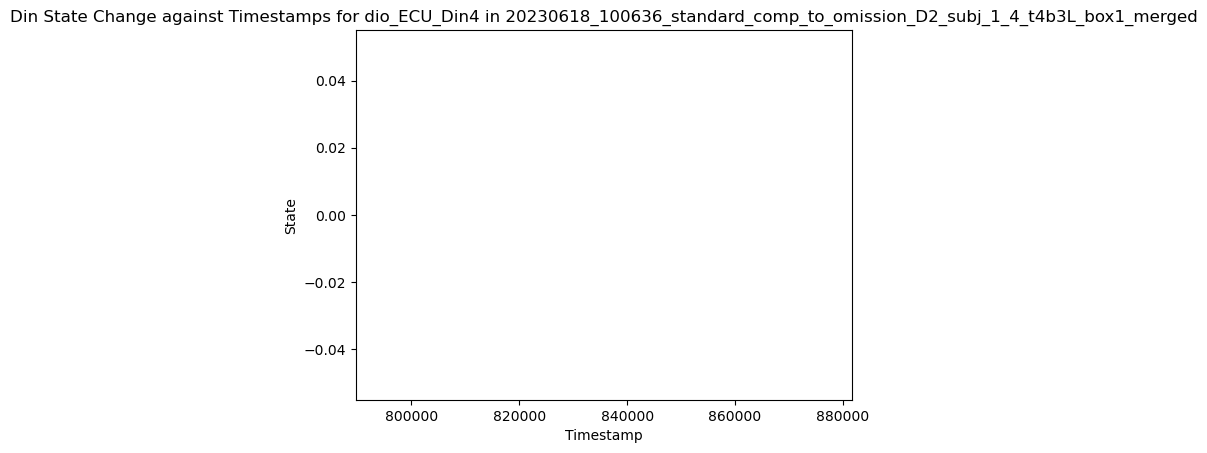

dio_ECU_Din1


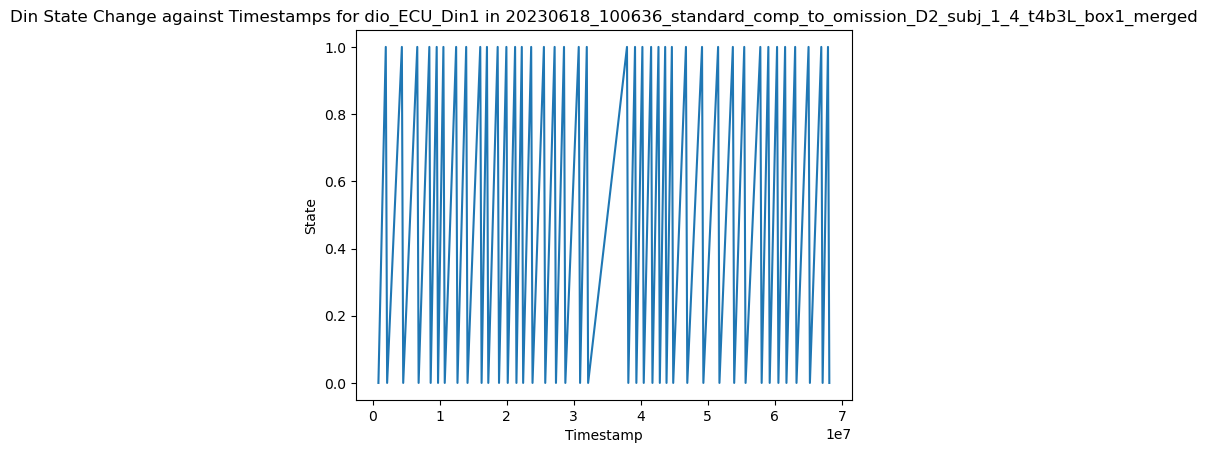

In [11]:
session_to_din_state_df = {}
for session, file_to_data in session_to_dir.items():
    all_recording_din_state_df = []
    for recording_name, subdir_dict in file_to_data.items():
        print(recording_name)
        current_recording_din_state_df = []

        try:
            voltage_timestamp_array = file_to_data[recording_name]["raw"]["timestamps"]["data"]
            for key, value in file_to_data[recording_name]["DIO"].items():
                if "in" in key:
                    print(key)
                    din_state_array = file_to_data[recording_name]["DIO"][key]["data"]
                    current_din_state_df = pd.DataFrame(din_state_array)
                    current_din_state_df["recording_path"] = session_to_path[session]
                    current_din_state_df["recording_dir"] = session
                    current_din_state_df["recording_file"] = recording_name
                    current_din_state_df["din"] = key
                    current_recording_din_state_df.append(current_din_state_df)
                    plt.plot([tup[0] for tup in din_state_array], [tup[1] for tup in din_state_array])
                    plt.xlabel("Timestamp")
                    plt.ylabel("State")
                    plt.title("Din State Change against Timestamps for {} in {}".format(key, recording_name))
                    plt.show()
                    plt.close()
            concatted_per_recording_din_state_df = pd.concat(current_recording_din_state_df).sort_values(by=["recording_file", "din"]).reset_index(drop=True)
            concatted_per_recording_din_state_df["time_stamp_index"] = concatted_per_recording_din_state_df["time"] - voltage_timestamp_array[0][0]
            all_recording_din_state_df.append(concatted_per_recording_din_state_df)
        except Exception as e: 
            print(e)
    concatted_all_recording_din_state_df = pd.concat(all_recording_din_state_df)
    session_to_din_state_df[session] = concatted_all_recording_din_state_df

# LOOP 3 Adding the video timestamps

In [12]:
session_to_din_state_df.keys()

dict_keys(['20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1'])

In [13]:
all_frame_to_timestamps_df = []
session_to_din_with_frames_df = {}
for session_path in all_session_files:   
    try:
        session_basename = os.path.splitext(os.path.basename(session_path))[0]
        print("Current Session: {}".format(session_basename))
        file_to_video_timestamps = {}
        for video_timestamps in glob.glob(os.path.join(session_path, "*cameraHWSync")):
            video_basename = os.path.basename(video_timestamps)
            print("Current Video Name: {}".format(video_basename))
            timestamp_array = trodes.read_exported.read_trodes_extracted_data_file(video_timestamps)["data"]["PosTimestamp"]
            file_to_video_timestamps[video_basename] = timestamp_array
            session_to_din_state_df[session_basename][os.path.basename(video_timestamps)] = session_to_din_state_df[session_basename]["time"].apply(lambda x: find_closest_index(sorted_list=timestamp_array, target=x))        
        
        # Find the maximum length of the arrays in the dictionary
        max_length = max(map(len, file_to_video_timestamps.values()))
        
        # Pad each array with NaN values to make them all the same length
        padded_data = {k: np.pad(v, (0, max_length - len(v)), mode='constant', constant_values=np.nan) for k, v in file_to_video_timestamps.items()}
        
        # Convert the padded data to a dataframe
        current_df = pd.DataFrame(padded_data)
        current_df.index = current_df.index.set_names(['video_frame'])
        current_df = current_df.reset_index()
        current_df = current_df.melt(id_vars="video_frame", value_vars=set(current_df.columns) - set(["video_frame"]), var_name='video_name', value_name='spikegadgets_timestampof_frame')      
        current_df["recording_basename"] = session_basename
        
        all_frame_to_timestamps_df.append(current_df)
        
    except Exception as e: 
        print(e)

pd.concat(all_frame_to_timestamps_df).to_csv(os.path.join(OUTPUT_DIR, "./{}_frame_to_timestamps.csv".format(OUTPUT_PREFIX)))

Current Session: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1
Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync


/nancy/projects/nose_poke_identifier/results/2023_09_07_nose_poke_extraction/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)


Current Video Name: 20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.videoTimeStamps.cameraHWSync


/nancy/projects/nose_poke_identifier/results/2023_09_07_nose_poke_extraction/../../src/trodes/read_exported.py:62: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(dtype_spec)
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:147: RuntimeWarning: invalid value encountered in cast
  padded[left_slice] = value_pair[0]
/home/riwata/miniconda3/envs/spike_interface_0_97_1/lib/python3.9/site-packages/numpy/lib/arraypad.py:151: RuntimeWarning: invalid value encountered in cast
  padded[right_slice] = value_pair[1]


In [14]:
pd.concat(all_frame_to_timestamps_df)

,video_frame,video_name,spikegadgets_timestampof_frame,recording_basename
0,0,20230618_100636_standard_comp_to_omission_D2_s...,835678,20230618_100636_standard_comp_to_omission_D2_s...
1,1,20230618_100636_standard_comp_to_omission_D2_s...,837064,20230618_100636_standard_comp_to_omission_D2_s...
2,2,20230618_100636_standard_comp_to_omission_D2_s...,838450,20230618_100636_standard_comp_to_omission_D2_s...
3,3,20230618_100636_standard_comp_to_omission_D2_s...,838450,20230618_100636_standard_comp_to_omission_D2_s...
4,4,20230618_100636_standard_comp_to_omission_D2_s...,839835,20230618_100636_standard_comp_to_omission_D2_s...
...,...,...,...,...
136985,68490,20230618_100636_standard_comp_to_omission_D2_s...,0,20230618_100636_standard_comp_to_omission_D2_s...
136986,68491,20230618_100636_standard_comp_to_omission_D2_s...,0,20230618_100636_standard_comp_to_omission_D2_s...
136987,68492,20230618_100636_standard_comp_to_omission_D2_s...,0,20230618_100636_standard_comp_to_omission_D2_s...
136988,68493,20230618_100636_standard_comp_to_omission_D2_s...,0,20230618_100636_standard_comp_to_omission_D2_s...


In [15]:
session_to_din_state_df[list(session_to_din_state_df.keys())[0]]

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync,20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.videoTimeStamps.cameraHWSync
0,835680,0,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,0,0,0
1,1934930,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1099250,1097,1097
2,2134930,0,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,1299250,1296,1296
3,4334936,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3499256,3492,3492
4,4534932,0,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din1,3699252,3692,3692
...,...,...,...,...,...,...,...,...,...
3866,69404308,0,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68568628,68469,68439
3867,69405905,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68570225,68471,68441
3868,69414308,0,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68578628,68479,68449
3869,69418105,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din3,68582425,68483,68453


# LOOP 4: Combining the video columns

In [16]:
session_to_tone_stamp_df = {}
for session, timestamps_df in session_to_din_state_df.items():
    current_timestamps_df = timestamps_df[(timestamps_df["din"] == TONE_DIN) & (timestamps_df["state"] == TONE_STATE)].reset_index(drop=True)
    camera_col = [col for col in current_timestamps_df.columns if "cameraHWSync" in col]
    id_col = [col for col in current_timestamps_df.columns if "cameraHWSync" not in col]
    
    current_timestamps_df = current_timestamps_df.melt(id_vars=id_col, value_vars=camera_col, var_name='video_file', value_name='video_frame')

    current_timestamps_df["video_file"] = current_timestamps_df["video_file"].apply(lambda x: x.strip("videoTimeStamps.cameraHWSync"))
    current_timestamps_df["video_number"] = current_timestamps_df["video_file"].apply(lambda x: x.split(".")[-1])
    current_timestamps_df["subject_info"] = current_timestamps_df["recording_file"].apply(lambda x: x.split("subj")[-1].strip("merged").strip("_"))
    session_to_tone_stamp_df[session]  = current_timestamps_df

In [17]:
session_to_tone_stamp_df[session]

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info
0,1624532,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,788852,20230618_100636_standard_comp_to_omission_D2_s...,787,1,1_1_t1b2L_box2
1,1674332,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,838652,20230618_100636_standard_comp_to_omission_D2_s...,837,1,1_1_t1b2L_box2
2,1676332,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,840652,20230618_100636_standard_comp_to_omission_D2_s...,839,1,1_1_t1b2L_box2
3,1708532,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,872852,20230618_100636_standard_comp_to_omission_D2_s...,871,1,1_1_t1b2L_box2
4,1741529,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,905849,20230618_100636_standard_comp_to_omission_D2_s...,904,1,1_1_t1b2L_box2
...,...,...,...,...,...,...,...,...,...,...,...
2637,68405706,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,67570026,20230618_100636_standard_comp_to_omission_D2_s...,67442,2,1_4_t4b3L_box1
2638,68583106,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,67747426,20230618_100636_standard_comp_to_omission_D2_s...,67619,2,1_4_t4b3L_box1
2639,69052305,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,68216625,20230618_100636_standard_comp_to_omission_D2_s...,68088,2,1_4_t4b3L_box1
2640,69242705,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,68407025,20230618_100636_standard_comp_to_omission_D2_s...,68278,2,1_4_t4b3L_box1


In [18]:
concatenated_tone_stamp_df = pd.concat(session_to_tone_stamp_df.values()).reset_index(drop=True)

In [19]:
concatenated_tone_stamp_df.head()

,time,state,recording_path,recording_dir,recording_file,din,time_stamp_index,video_file,video_frame,video_number,subject_info
0,1624532,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,788852,20230618_100636_standard_comp_to_omission_D2_s...,787,1,1_1_t1b2L_box2
1,1674332,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,838652,20230618_100636_standard_comp_to_omission_D2_s...,837,1,1_1_t1b2L_box2
2,1676332,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,840652,20230618_100636_standard_comp_to_omission_D2_s...,839,1,1_1_t1b2L_box2
3,1708532,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,872852,20230618_100636_standard_comp_to_omission_D2_s...,871,1,1_1_t1b2L_box2
4,1741529,1,../../data/spike_gadgets/20230618_100636_stand...,20230618_100636_standard_comp_to_omission_D2_s...,20230618_100636_standard_comp_to_omission_D2_s...,dio_ECU_Din2,905849,20230618_100636_standard_comp_to_omission_D2_s...,904,1,1_1_t1b2L_box2


In [20]:
concatenated_tone_stamp_df.to_csv(os.path.join(OUTPUT_DIR, "{}_tone_timestamp.csv".format(OUTPUT_PREFIX)))